In [34]:
import pandas as pd
import numpy as np
import datetime
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import pandas as pd

# Load the CSV file
students = pd.read_csv("student-mat.csv")

# Display the first few rows
print(students.head())

  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  ...  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher  ...   
1     GP   F   17       U     GT3       T     1     1  at_home     other  ...   
2     GP   F   15       U     LE3       T     1     1  at_home     other  ...   
3     GP   F   15       U     GT3       T     4     2   health  services  ...   
4     GP   F   16       U     GT3       T     3     3    other     other  ...   

  famrel freetime  goout  Dalc  Walc health absences  G1  G2  G3  
0      4        3      4     1     1      3        6   5   6   6  
1      5        3      3     1     1      3        4   5   5   6  
2      4        3      2     2     3      3       10   7   8  10  
3      3        2      2     1     1      5        2  15  14  15  
4      4        3      2     1     2      5        4   6  10  10  

[5 rows x 33 columns]


In [5]:
print(students.info())

categorical_cols = ['Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health']
students[categorical_cols] = students[categorical_cols].astype('category')

print(students.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      395 non-null    object
 1   sex         395 non-null    object
 2   age         395 non-null    int64 
 3   address     395 non-null    object
 4   famsize     395 non-null    object
 5   Pstatus     395 non-null    object
 6   Medu        395 non-null    int64 
 7   Fedu        395 non-null    int64 
 8   Mjob        395 non-null    object
 9   Fjob        395 non-null    object
 10  reason      395 non-null    object
 11  guardian    395 non-null    object
 12  traveltime  395 non-null    int64 
 13  studytime   395 non-null    int64 
 14  failures    395 non-null    int64 
 15  schoolsup   395 non-null    object
 16  famsup      395 non-null    object
 17  paid        395 non-null    object
 18  activities  395 non-null    object
 19  nursery     395 non-null    object
 20  higher    

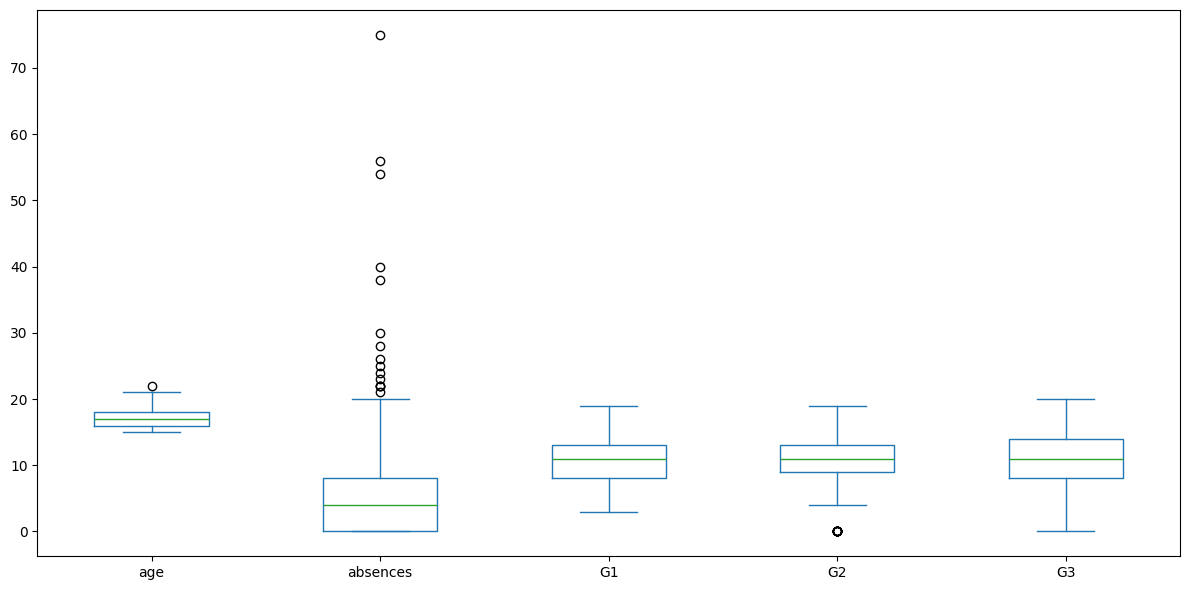

In [6]:
studens_num = students.select_dtypes(include='number')

studens_num.plot(kind='box', figsize=(12, 6))
plt.tight_layout()
plt.show()


In [7]:
students = students[students['absences'] < 20]

print(students.describe(include='all'))


       school  sex         age address famsize Pstatus   Medu   Fedu   Mjob  \
count     376  376  376.000000     376     376     376  376.0  376.0    376   
unique      2    2         NaN       2       2       2    5.0    5.0      5   
top        GP    F         NaN       U     GT3       T    4.0    2.0  other   
freq      330  194         NaN     291     266     338  124.0  111.0    132   
mean      NaN  NaN   16.659574     NaN     NaN     NaN    NaN    NaN    NaN   
std       NaN  NaN    1.269567     NaN     NaN     NaN    NaN    NaN    NaN   
min       NaN  NaN   15.000000     NaN     NaN     NaN    NaN    NaN    NaN   
25%       NaN  NaN   16.000000     NaN     NaN     NaN    NaN    NaN    NaN   
50%       NaN  NaN   17.000000     NaN     NaN     NaN    NaN    NaN    NaN   
75%       NaN  NaN   18.000000     NaN     NaN     NaN    NaN    NaN    NaN   
max       NaN  NaN   22.000000     NaN     NaN     NaN    NaN    NaN    NaN   

         Fjob  ... famrel freetime  goout   Dalc   

In [8]:
print(students.isna().sum())

school        0
sex           0
age           0
address       0
famsize       0
Pstatus       0
Medu          0
Fedu          0
Mjob          0
Fjob          0
reason        0
guardian      0
traveltime    0
studytime     0
failures      0
schoolsup     0
famsup        0
paid          0
activities    0
nursery       0
higher        0
internet      0
romantic      0
famrel        0
freetime      0
goout         0
Dalc          0
Walc          0
health        0
absences      0
G1            0
G2            0
G3            0
dtype: int64


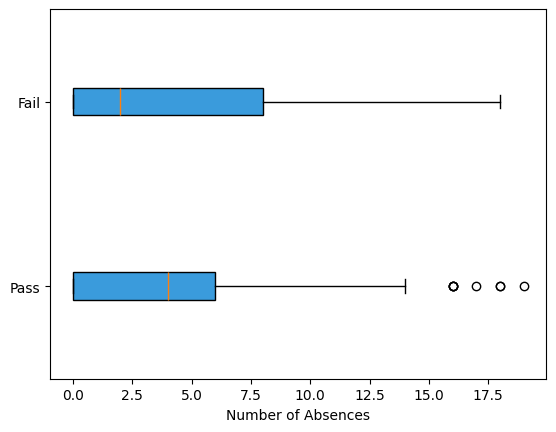

In [9]:
pass_students = students[students['G3'] >= 10]
fail_students = students[students['G3'] < 10]

plt.boxplot([pass_students['absences'], fail_students['absences']],
            vert=False,
            labels=["Pass", "Fail"],
            patch_artist=True,
            boxprops=dict(facecolor='#3A9BDC'))

plt.xlabel("Number of Absences")
plt.show()

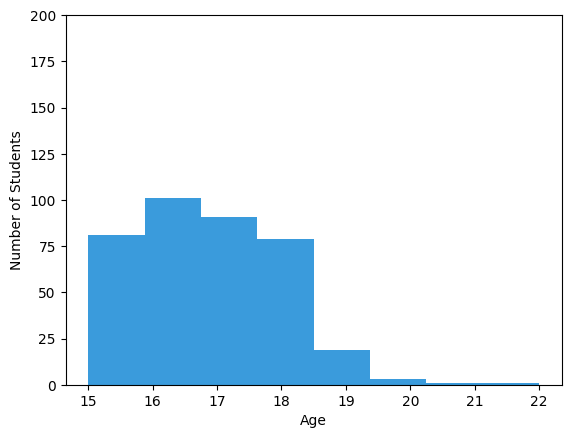

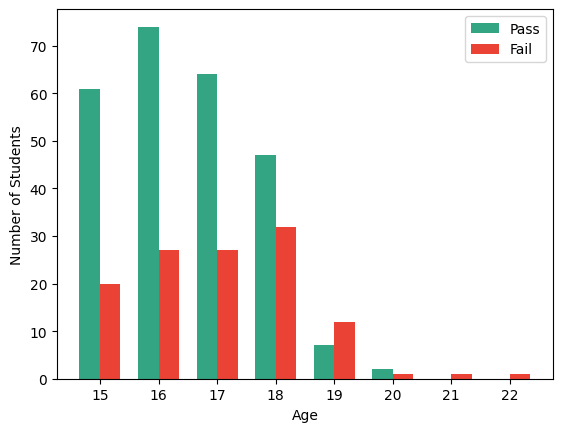

In [10]:
# Histogram of student ages
plt.hist(students['age'], bins=8, color='#3A9BDC')
plt.xlabel("Age")
plt.ylabel("Number of Students")
plt.ylim(0, 200)
plt.show()

# Pass age distribution
pass_age = pass_students['age'].value_counts().sort_index().reset_index()
pass_age.columns = ['age', 'count']

# Add missing ages 21 and 22 with count 0
for missing_age in [21, 22]:
    if missing_age not in pass_age['age'].values:
        pass_age = pd.concat([pass_age, pd.DataFrame({'age': [missing_age], 'count': [0]})], ignore_index=True)

# Fail age distribution
fail_age = fail_students['age'].value_counts().sort_index().reset_index()
fail_age.columns = ['age', 'count']

# Merge pass and fail age counts
plot_age = pd.merge(pass_age, fail_age, on='age', how='left', suffixes=('_pass', '_fail'))
plot_age['count_fail'] = plot_age['count_fail'].fillna(0).astype(int)
plot_age = plot_age.sort_values(by='age')

# Bar plot
bar_width = 0.35
x = np.arange(len(plot_age['age']))

plt.bar(x - bar_width/2, plot_age['count_pass'], width=bar_width, label='Pass', color='#34A583')
plt.bar(x + bar_width/2, plot_age['count_fail'], width=bar_width, label='Fail', color='#EA4335')
plt.xlabel('Age')
plt.ylabel('Number of Students')
plt.xticks(ticks=x, labels=plot_age['age'])
plt.legend()
plt.show()


C:\Users\prana\AppData\Local\Temp\ipykernel_23384\1040799859.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  plot_study = students.groupby('studytime')['G3'].mean().reset_index()


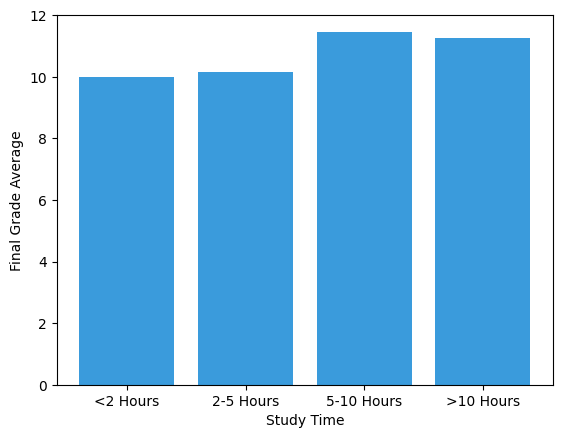

In [11]:
plot_study = students.groupby('studytime')['G3'].mean().reset_index()

plt.bar(plot_study['studytime'],
        plot_study['G3'],
        tick_label=['<2 Hours', '2-5 Hours', '5-10 Hours', '>10 Hours'],
        color='#3A9BDC')

plt.xlabel("Study Time")
plt.ylabel("Final Grade Average")
plt.ylim(0, 12)
plt.show()

C:\Users\prana\AppData\Local\Temp\ipykernel_23384\768742108.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  plot_medu = students.groupby('Medu')['G3'].mean().reset_index()
C:\Users\prana\AppData\Local\Temp\ipykernel_23384\768742108.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  plot_fedu = students.groupby('Fedu')['G3'].mean().reset_index()


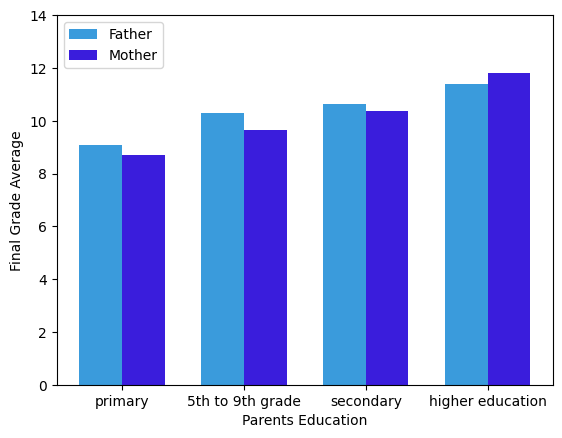

In [15]:
plot_medu = students.groupby('Medu')['G3'].mean().reset_index()
plot_fedu = students.groupby('Fedu')['G3'].mean().reset_index()

plot_parent = plot_fedu.copy()
plot_parent['fedu_G3'] = plot_fedu['G3']
plot_parent['medu_G3'] = plot_medu['G3']

plot_subset = plot_parent.iloc[1:5]  # selecting levels 2 to 5

bar_width = 0.35
x = np.arange(len(plot_subset))

plt.bar(x - bar_width/2, plot_subset['fedu_G3'], width=bar_width, label='Father', color='#3A9BDC')
plt.bar(x + bar_width/2, plot_subset['medu_G3'], width=bar_width, label='Mother', color='#3A1DDC')

plt.xticks(ticks=x, labels=['primary', '5th to 9th grade', 'secondary', 'higher education'])
plt.xlabel("Parents Education")
plt.ylabel("Final Grade Average")
plt.ylim(0, 14)
plt.legend(loc='upper left')
plt.show()


  schoolsup famsup         G3
0        no     no  10.731343
1        no    yes  10.424870
2       yes     no  10.538462
3       yes    yes   9.083333


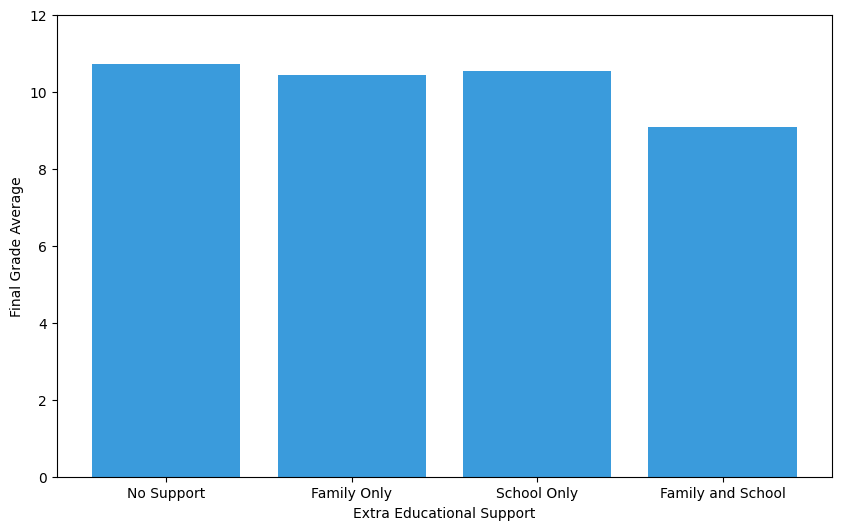

In [16]:
plot_schoolsup = students.groupby(['schoolsup', 'famsup'])['G3'].mean().reset_index()
print(plot_schoolsup)

plt.figure(figsize=(10, 6))
plt.bar(range(len(plot_schoolsup)), plot_schoolsup['G3'], color='#3A9BDC')
plt.xlabel('Extra Educational Support')
plt.ylabel('Final Grade Average')
plt.xticks(range(len(plot_schoolsup)), ['No Support', 'Family Only', 'School Only', 'Family and School'])
plt.ylim(0, 12)
plt.show()

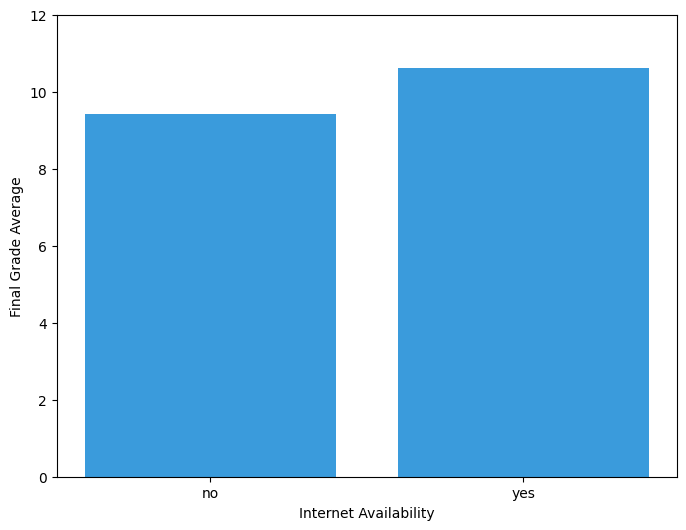

In [17]:
plot_internet = students.groupby('internet')['G3'].mean().reset_index()

plt.figure(figsize=(8, 6))
plt.bar(plot_internet['internet'], plot_internet['G3'], color='#3A9BDC')
plt.xlabel('Internet Availability')
plt.ylabel('Final Grade Average')
plt.ylim(0, 12)
plt.show()

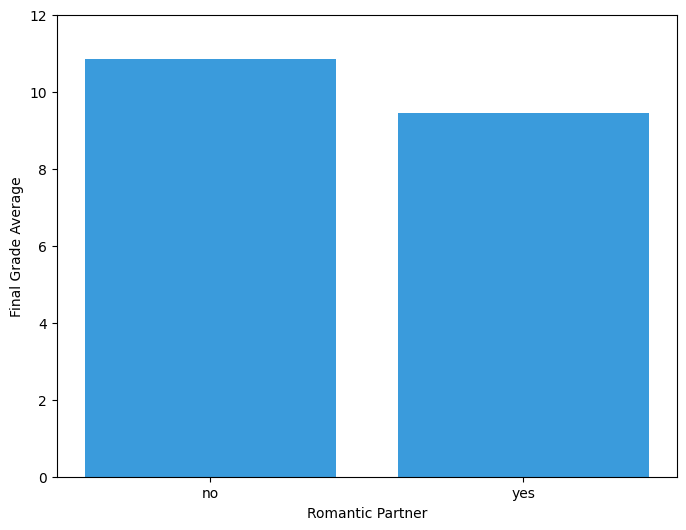

In [18]:
plot_romantic = students.groupby('romantic')['G3'].mean().reset_index()

plt.figure(figsize=(8, 6))
plt.bar(plot_romantic['romantic'], plot_romantic['G3'], color='#3A9BDC')
plt.xlabel('Romantic Partner')
plt.ylabel('Final Grade Average')
plt.ylim(0, 12)
plt.show()

In [19]:
# alcohol consumption

In [20]:
# health

In [21]:
# sick-students

In [22]:
## Data preprocessing

students = students.assign(status=pd.Categorical(["Pass" if g >= 10 else "Fail" for g in students["G3"]]))
students = students.drop(columns=["G3"])

print(students.info())

<class 'pandas.core.frame.DataFrame'>
Index: 376 entries, 0 to 394
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   school      376 non-null    object  
 1   sex         376 non-null    object  
 2   age         376 non-null    int64   
 3   address     376 non-null    object  
 4   famsize     376 non-null    object  
 5   Pstatus     376 non-null    object  
 6   Medu        376 non-null    category
 7   Fedu        376 non-null    category
 8   Mjob        376 non-null    object  
 9   Fjob        376 non-null    object  
 10  reason      376 non-null    object  
 11  guardian    376 non-null    object  
 12  traveltime  376 non-null    category
 13  studytime   376 non-null    category
 14  failures    376 non-null    category
 15  schoolsup   376 non-null    object  
 16  famsup      376 non-null    object  
 17  paid        376 non-null    object  
 18  activities  376 non-null    object  
 19  nursery     3

In [ ]:
# cross validation

np.random.seed(1)

# Random Index Sampling
index = np.random.choice(students.shape[0],
                         size=int(0.8 * students.shape[0]),
                         replace=False)

# Train-Test Split
students_train = students.iloc[index]
students_test = students.iloc[~students.index.isin(students.iloc[index].index)]

In [24]:
status_counts = students_train['status'].value_counts()

# Calculate proportions
status_proportions = status_counts / status_counts.sum()

print(status_proportions)

status
Pass    0.683333
Fail    0.316667
Name: count, dtype: float64


In [26]:
from sklearn.utils import resample

majority_class = students_train[students_train['status'] == students_train['status'].value_counts().idxmax()]
minority_class = students_train[students_train['status'] == students_train['status'].value_counts().idxmin()]

# Upsample minority class to match majority class size
minority_upsampled = resample(minority_class,
                             replace=True,  # sample with replacement
                             n_samples=len(majority_class),  # match majority class
                             random_state=1)  # reproducible results

# Combine majority class with upsampled minority class
students_train = pd.concat([majority_class, minority_upsampled])

# Calculate new proportions
status_counts = students_train['status'].value_counts()
status_proportions = status_counts / status_counts.sum()

print(status_proportions)

status
Fail    0.5
Pass    0.5
Name: count, dtype: float64


### Modeling

In [28]:
from sklearn.naive_bayes import CategoricalNB

X_train = students_train.drop('status', axis=1)
y_train = students_train['status']

X_train_encoded = X_train.copy()
for column in X_train.select_dtypes(include=['object', 'category']).columns:
    X_train_encoded[column] = X_train[column].astype('category').cat.codes

model_bayes = CategoricalNB(alpha=1)  # alpha=1 is equivalent to Laplace smoothing
model_bayes.fit(X_train_encoded, y_train)

CategoricalNB(alpha=1)

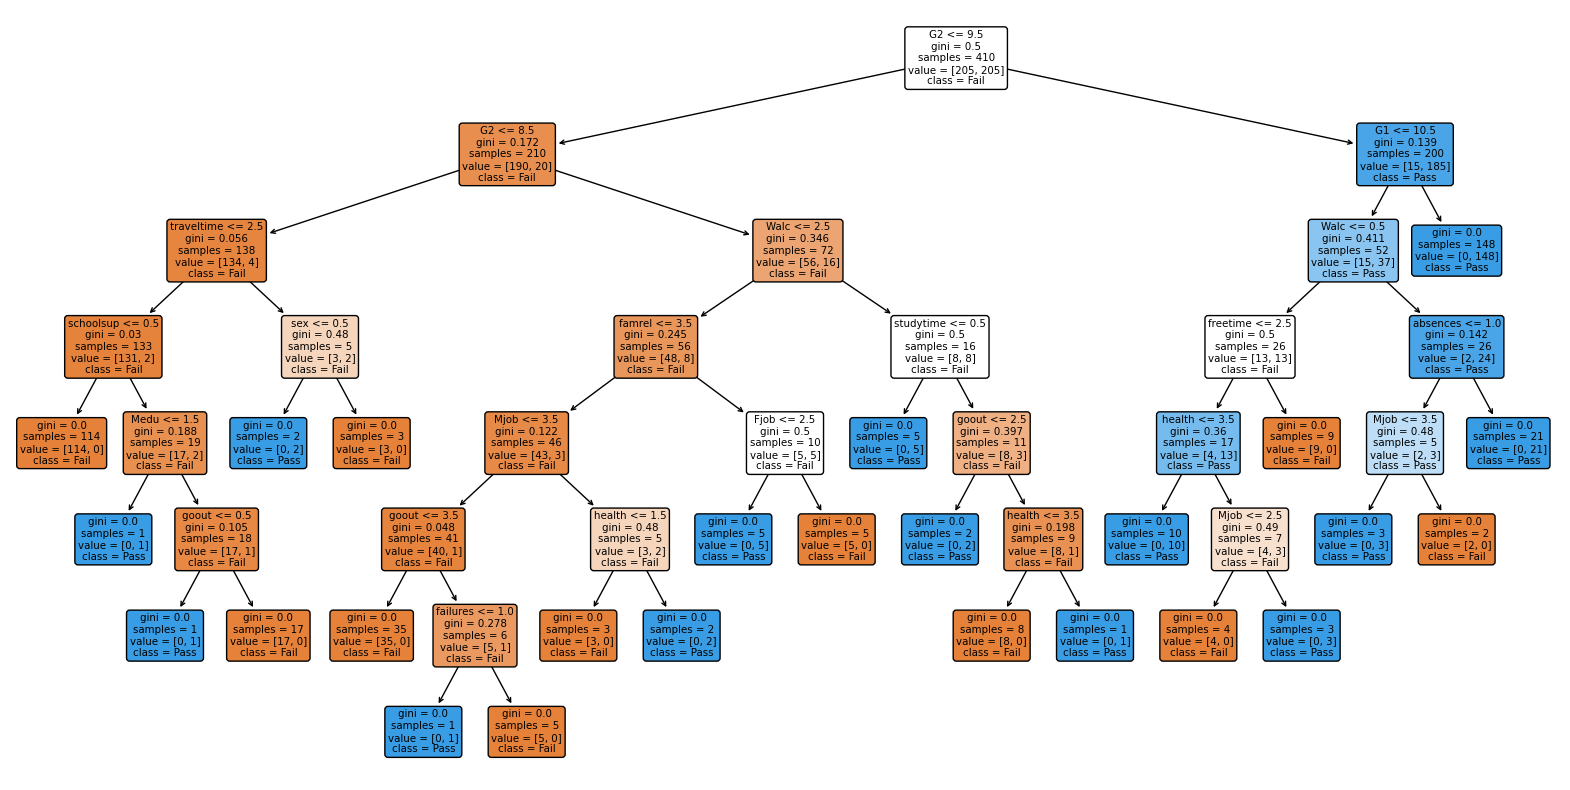

In [30]:
from sklearn import tree

X_train = students_train.drop('status', axis=1)
y_train = students_train['status']

X_train_encoded = X_train.copy()

for column in X_train.select_dtypes(include=['object', 'category']).columns:
    X_train_encoded[column] = X_train[column].astype('category').cat.codes

model_dtree = DecisionTreeClassifier()
model_dtree.fit(X_train_encoded, y_train)

plt.figure(figsize=(20, 10))

tree.plot_tree(model_dtree,
                feature_names=X_train_encoded.columns,
                class_names=model_dtree.classes_,
                filled=True,
                rounded=True)
plt.show()

In [31]:
import numpy as np
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier

np.random.seed(1)
X_train = students_train.drop('status', axis=1)
y_train = students_train['status']
X_train_encoded = X_train.copy()
for column in X_train.select_dtypes(include=['object', 'category']).columns:
    X_train_encoded[column] = X_train[column].astype('category').cat.codes
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
rf = RandomForestClassifier(random_state=1)
param_grid = {
    'n_estimators': [100, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}
model_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)
model_rf.fit(X_train_encoded, y_train)
print("Best parameters:", model_rf.best_params_)
print("Best CV score:", model_rf.best_score_)

Fitting 15 folds for each of 36 candidates, totalling 540 fits
Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 100}
Best CV score: 0.9390243902439025


Training Confusion Matrix:
[[189  16]
 [ 26 179]]

Training Classification Report:
              precision    recall  f1-score   support

        Fail       0.88      0.92      0.90       205
        Pass       0.92      0.87      0.89       205

    accuracy                           0.90       410
   macro avg       0.90      0.90      0.90       410
weighted avg       0.90      0.90      0.90       410


Testing Confusion Matrix:
[[25  1]
 [ 7 43]]

Testing Classification Report:
              precision    recall  f1-score   support

        Fail       0.78      0.96      0.86        26
        Pass       0.98      0.86      0.91        50

    accuracy                           0.89        76
   macro avg       0.88      0.91      0.89        76
weighted avg       0.91      0.89      0.90        76


Probability predictions (first few rows):
[[9.96142312e-01 3.85768838e-03]
 [9.54334120e-05 9.99904567e-01]
 [9.76416552e-01 2.35834477e-02]
 [6.64768359e-04 9.99335232e-01]
 [3.955654

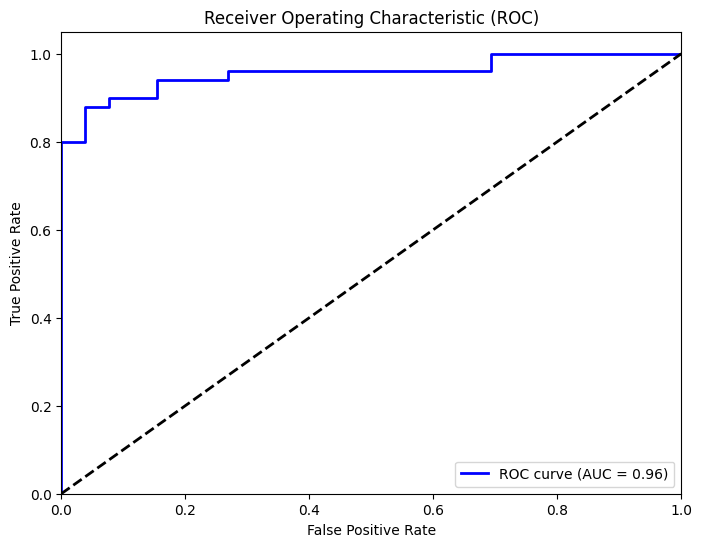


AUC value: 0.9561538461538461


In [35]:
# Model evaluation

from sklearn.preprocessing import LabelEncoder

# Prepare test data
X_test = students_test.drop('status', axis=1)
y_test = students_test['status']

# Encode test data the same way as training data
X_test_encoded = X_test.copy()
for column in X_test.select_dtypes(include=['object', 'category']).columns:
    X_test_encoded[column] = X_test[column].astype('category').cat.codes

# Training evaluation
y_train_pred = model_bayes.predict(X_train_encoded)
train_cm = confusion_matrix(students_train['status'], y_train_pred)
train_report = classification_report(students_train['status'], y_train_pred)

print("Training Confusion Matrix:")
print(train_cm)
print("\nTraining Classification Report:")
print(train_report)

# Testing evaluation
y_test_pred = model_bayes.predict(X_test_encoded)
test_cm = confusion_matrix(y_test, y_test_pred)
test_report = classification_report(y_test, y_test_pred)

print("\nTesting Confusion Matrix:")
print(test_cm)
print("\nTesting Classification Report:")
print(test_report)

# Get probability predictions
prob_bayes = model_bayes.predict_proba(X_test_encoded)
print("\nProbability predictions (first few rows):")
print(prob_bayes[:5])

# Calculate ROC curve and AUC
# First, ensure target is numeric (0 for "Fail", 1 for "Pass")
le = LabelEncoder()
le.fit(["Fail", "Pass"])
y_test_numeric = le.transform(y_test)

# Get index of "Pass" class
pass_idx = np.where(model_bayes.classes_ == "Pass")[0][0]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test_numeric, prob_bayes[:, pass_idx], pos_label=1)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

print(f"\nAUC value: {roc_auc}")


In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

# Assuming model_dtree, students_train are already defined
# Predict on training data
predict_dtree = model_dtree.predict(students_train.drop('status', axis=1))

# Compute confusion matrix
cm = confusion_matrix(students_train['status'], predict_dtree, labels=['Pass', 'Fail'])

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Pass', 'Fail'])
disp.plot()